## Import WV2

In [2]:
# coding: utf-8

import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube import Datacube
from skimage import exposure
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask
import geopandas as gpd
import affine
import scipy.interpolate
from scipy import ndimage as nd
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling
import SpatialTools

# Connect to datacube database
dc = datacube.Datacube(app='Time series animation')


def interpolate_2d(ds, x_coords, y_coords, z_coords, 
                 method='linear', fill_nearest=False, sigma=None):
    
    '''
    This function takes points with X, Y and Z coordinates, and interpolates Z-values
    across the extent of an existing xarray dataset. This can be useful for producing 
    smooth surfaces from point data that can be compared directly against satellite
    data derived from an OpenDataCube query.
    
    Last modified: August 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    ds_array : xarray DataArray or Dataset
        A two-dimensional or multi-dimensional array from which x and y dimensions will be 
        copied and used for the area in which to interpolate point data. 
    x_coords : numpy array
        An array containing X coordinates for all points (e.g. longitudes). 
    y_coords : numpy array
        An array containing Y coordinates for all points (e.g. latitudes).
    z_coords : numpy array
        An array containing Z coordinates for all points (e.g. elevations). These are the 
        values you wish to interpolate between.
    method : string, optional
        The method used to interpolate between point values. This string is passed to 
        `scipy.interpolate.griddata`; the default is 'linear' and options include
        'linear', 'nearest' and 'cubic'.
    fill_nearest : boolean, optional
        A boolean value indicating whether to fill NaN areas outside of the extent of 
        the input X and Y coordinates with the value of the nearest pixel. By default,
        `scipy.interpolate.griddata` only returns interpolated values for the convex hull
        of the of the input points, so this variable can be used to provide results for
        all pixels instead. Warning: this can produce significant artefacts for areas
        located far from the nearest point.
    sigma : None or int, optional
        An optional integer value can be provided to smooth the interpolated surface
        using a guassian filter. Higher values of sigma result in a smoother surface
        that may loose some of the detail in the original interpolated layer.        
      
    Returns
    -------
    interp_2d_array : xarray DataArray
        An xarray DataArray containing with x and y coordinates copied from `ds_array`,
        and Z-values interpolated from the points data. 
        
    '''
    
    # Extract xy and elev points
    points_xy = np.vstack([x_coords, y_coords]).T

    # Create grid to interpolate into
    grid_y, grid_x = np.meshgrid(ds.x, ds.y)  

    # Interpolate x, y and z values using linear/TIN interpolation
    out = scipy.interpolate.griddata(points=points_xy, 
                                     values=z_coords, 
                                     xi=(grid_y, grid_x), 
                                     method=method)

    # Calculate nearest
    if fill_nearest:
        
        nearest_inds = nd.distance_transform_edt(input=np.isnan(out), 
                                                 return_distances=False, 
                                                 return_indices=True)
        out = out[tuple(nearest_inds)]
        
    # Apply guassian filter        
    if sigma:

        out = nd.filters.gaussian_filter(out, sigma=sigma)
        
    # Create xarray dataarray from the data
    interp_2d_array = xr.DataArray(out, coords=[ds.y, ds.x], dims=['y', 'x']) 
        
    return interp_2d_array




lat, lon, buffer_m = -11.966952124241345, 136.5214347839318, 8000
time_range = ('2017', '2018')


# Set up analysis data query using a buffer around a lat-long point (1280 x 720).
# This simply converts a lat long to Australian Albers, then creates a square analysis region
# by creating a square buffer around the point.
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25)} 

DEAPlotting.display_map(x=query['x'], y=query['y'])


In [366]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query,
                                               sensors=['ls8'],
                                               masked_prop=0.99, 
                                               mask_pixel_quality=True,
                                               mask_invalid_data=True)

Loading ls8
    Loading 4 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [367]:
landsat_ds['AWEI'] = ((4 * (landsat_ds.green * 0.0001 - landsat_ds.swir1 * 0.0001) - 
                      (0.25 * landsat_ds.nir * 0.0001 + 2.75 * landsat_ds.swir2 * 0.0001)))

# test = landsat_ds.isel(time=3).sel(y=slice(-1272500, -1276500), x=slice(496000, 500000))
# test[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
# awei_array = test.AWEI

In [368]:
landsat_ds = landsat_ds.median(dim='time', keep_attrs=True)

### Import shapefile

In [369]:
import geopandas as gpd
from skimage.filters import threshold_otsu

def cmask(array, index=(0, 0), radius=10, skipna=True):

    a, b = index
    nx,ny = array.shape
    y, x = np.ogrid[-a:nx-a, -b:ny-b]
    mask = x * x + y * y <= radius * radius    
    mask_vals = array[mask]
    
    if skipna:
        mask_vals = mask_vals[np.isfinite(mask_vals)]
    
    return mask_vals

# shoreline_gdf = gpd.read_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/Test_adaptiveOTSU/shoreline_line.shp').to_crs({'init': 'EPSG:3577'})

shoreline_gdf = SpatialTools.contour_extract(z_values=-0.25,
                             ds_array=landsat_ds.AWEI,
                             ds_crs=landsat_ds.geobox.crs,
                             ds_affine=landsat_ds.geobox.affine,
                             output_shp='/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/Test_adaptiveOTSU/contour.shp',
                             verbose=False,
                             min_vertices=2)

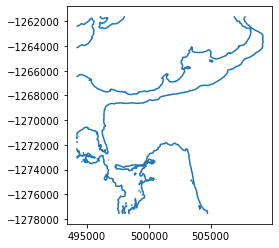

In [370]:
shoreline_gdf.plot()

### Create points along line

In [371]:
out = [shoreline_gdf.interpolate(dist).iloc[0] for dist in range(0, int(shoreline_gdf.length), 50)]
shoreline_points = gpd.GeoDataFrame(geometry=out, crs=shoreline_gdf.crs)   

In [372]:
# mask = rasterio.features.rasterize(shapes=[(shoreline_points.iloc[20].geometry, 1)],
#                                    out_shape=(landsat_ds.dims['y'], landsat_ds.dims['x']),
#                                    transform=landsat_ds.geobox.transform)

In [373]:
# import matplotlib.pyplot as plt
# plt.imshow(mask)

In [374]:
np_array = landsat_ds.AWEI.values



In [375]:
xx = shoreline_points.geometry.x
yy = shoreline_points.geometry.y
col, row = ~landsat_ds.geobox.transform * (xx, yy)
col = col.astype(int)
row = row.astype(int)

In [387]:
radius = 3

out = []
for i in range(0, len(shoreline_points)):

    index_vals = cmask(index=(row[i], col[i]), radius=radius, array=np_array)
    try:
        otsu_thresh = threshold_otsu(index_vals)
    except:
        otsu_thresh = np.nan
    out.append(otsu_thresh)

In [388]:
shoreline_points['otsu'] = out

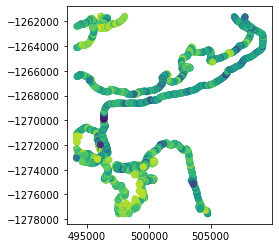

In [389]:
shoreline_points.plot(column='otsu')

In [390]:
shoreline_points.to_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/Test_adaptiveOTSU/otsu_points.shp')

In [391]:
x_coords = shoreline_points.geometry.x
y_coords = shoreline_points.geometry.y
z_coords = shoreline_points.otsu

In [397]:
otsu_2d = interpolate_2d(landsat_ds, x_coords, y_coords, z_coords, 
                 method='linear', fill_nearest=True, sigma=50)

In [398]:
mask = rasterio.features.rasterize(shapes=[(shoreline_gdf.buffer(radius*25).geometry[0], 1)],
                                   out_shape=(landsat_ds.dims['y'], landsat_ds.dims['x']),
                                   transform=landsat_ds.geobox.transform)

In [399]:
otsu_2d = otsu_2d.where(mask)

In [403]:
(otsu_2d + -0.25)/2

<xarray.DataArray (y: 641, x: 641)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 -1.262e+06 -1.262e+06 ... -1.278e+06 -1.278e+06
  * x        (x) float64 4.941e+05 4.942e+05 4.942e+05 ... 5.101e+05 5.101e+05

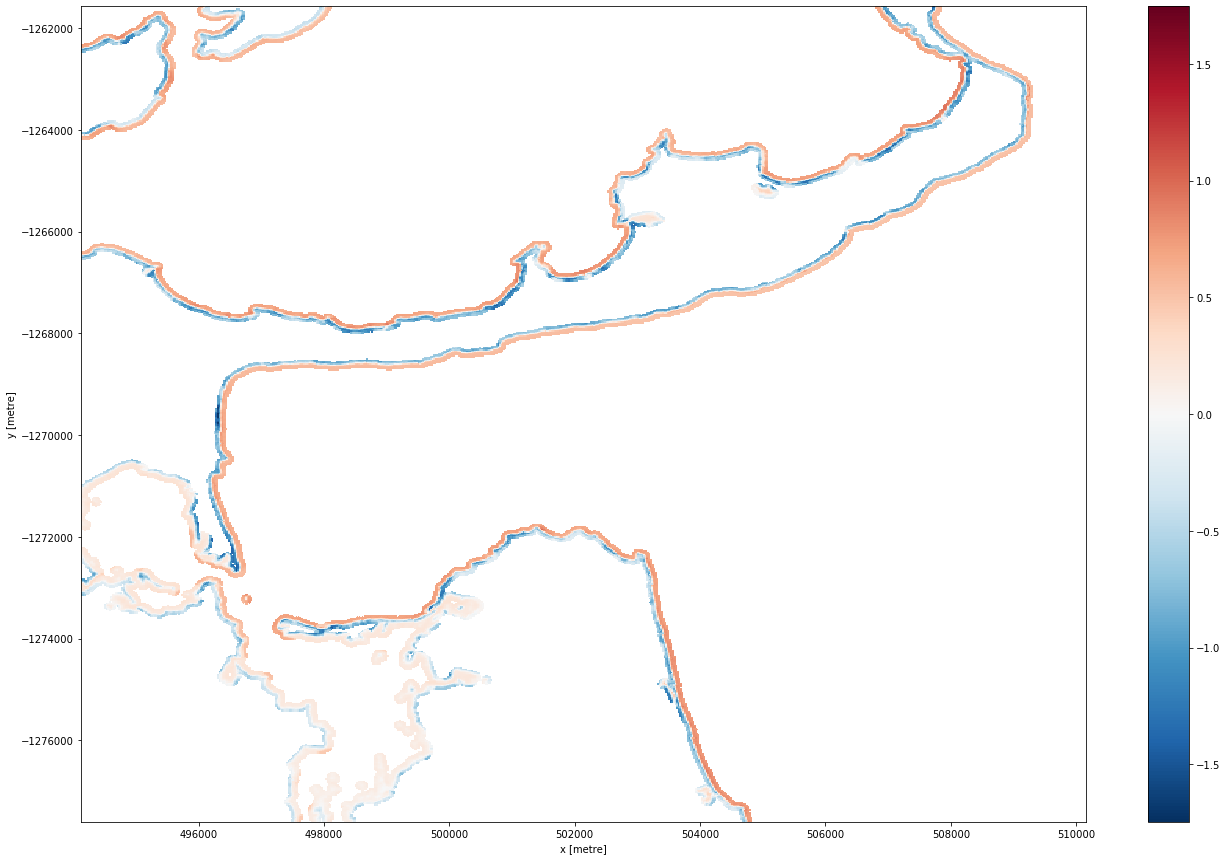

In [404]:
(landsat_ds.AWEI - (otsu_2d + -0.25)/2).plot(size=15)

In [406]:
output_contour = SpatialTools.contour_extract(z_values=0.0,
                             ds_array=(landsat_ds.AWEI - (otsu_2d + -0.25)/2),
                             ds_crs=landsat_ds.geobox.crs,
                             ds_affine=landsat_ds.geobox.affine,
                             output_shp='/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/Test_adaptiveOTSU/contour.shp',
                             verbose=False,
                             min_vertices=2)

In [ ]:
awei_array.plot(robust=True)

In [8]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

rescaled_vals = exposure.rescale_intensity(awei_array.fillna(0).values, out_range='uint8').astype('uint8')
selem = disk(10)
local_hist = rank.windowed_histogram(rescaled_vals, selem)
local_otsu = rank.otsu(rescaled_vals, selem)


In [31]:
# # a : 2D array of indices, b : 3D array from where values are to be picked up
# m,n = a.shape
# I,J = np.ogrid[:m,:n]
# out = b[a, I, J] # or b[a, np.arange(m)[:,None],np.arange(n)]


np.random.seed(1234)
a = local_otsu
b = np.transpose(local_hist, axes=[2, 0, 1])
print(a)  # Index array

print(b)  # values array

m,n = a.shape
I,J = np.ogrid[:m,:n]
out = b[a, I, J]

[[190 190 197 ... 235 235 235]
 [203 190 197 ... 235 235 235]
 [222 203 201 ... 235 236 235]
 ...
 [112 112 112 ... 122 122 122]
 [113 113 112 ... 122 122 122]
 [113 113 113 ... 122 122 122]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0

array([[0.01111111, 0.01      , 0.00909091, ..., 0.01818182, 0.02      ,
        0.02222222],
       [0.01      , 0.00900901, 0.00819672, ..., 0.02459016, 0.01801802,
        0.02      ],
       [0.07272727, 0.00819672, 0.00746269, ..., 0.02238806, 0.01639344,
        0.01818182],
       ...,
       [0.01818182, 0.03278689, 0.02985075, ..., 0.01492537, 0.01639344,
        0.01818182],
       [0.01      , 0.00900901, 0.03278689, ..., 0.01639344, 0.01801802,
        0.02      ],
       [0.01111111, 0.01      , 0.00909091, ..., 0.01818182, 0.02      ,
        0.02222222]])

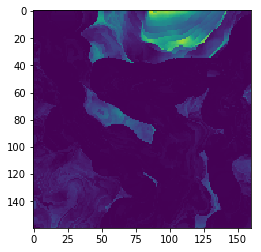

In [34]:
import matplotlib.pyplot as plt
plt.imshow(out)

In [30]:
np.transpose(local_hist, axes=[2, 0, 1])

(160, 160, 160, 160)

In [ ]:
def windowed_histogram_similarity(image, selem, reference_hist, n_bins):
    # Compute normalized windowed histogram feature vector for each pixel
    px_histograms = rank.windowed_histogram(image, selem, n_bins=n_bins)

    # Reshape coin histogram to (1,1,N) for broadcast when we want to use it in
    # arithmetic operations with the windowed histograms from the image
    reference_hist = reference_hist.reshape((1, 1) + reference_hist.shape)

    # Compute Chi squared distance metric: sum((X-Y)^2 / (X+Y));
    # a measure of distance between histograms
    X = px_histograms
    Y = reference_hist

    num = (X - Y) ** 2
    denom = X + Y
    denom[denom == 0] = np.infty
    frac = num / denom

    chi_sqr = 0.5 * np.sum(frac, axis=2)

    # Generate a similarity measure. It needs to be low when distance is high
    # and high when distance is low; taking the reciprocal will do this.
    # Chi squared will always be >= 0, add small value to prevent divide by 0.
    similarity = 1 / (chi_sqr + 1.0e-4)

    return similarity


In [ ]:
# landsat_ds.isel(time=3, x=slice(35, 75), y=slice(40, 80))[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

coin_hist, _ = np.histogram(rescaled_vals[40:80, 35:75], bins=256, density=True)
coin_hist = coin_hist.astype(float) / np.sum(coin_hist)
coin_hist

selem = disk(5)


quantized_img = rescaled_vals // 16

# Compute the similarity across the complete image
similarity = windowed_histogram_similarity(quantized_img, selem, coin_hist,
                                           coin_hist.shape[0])


In [ ]:
plt.imshow(similarity)

In [ ]:
plt.imshow(np.std(local_hist[:, :, :] * np.arange(0, 256, 1), axis=2))

In [ ]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
radius = 10
selem = disk(radius)

awei_array = test.AWEI

In [ ]:
global_otsu = threshold_otsu(awei_array.values[np.isfinite(awei_array.values)])

In [ ]:
import skimage.morphology
radius = 5
selem = disk(radius)
eroded = skimage.morphology.erosion(awei_array > 0, selem=selem)
plt.imshow(eroded )

In [ ]:
dilated = skimage.morphology.erosion(awei_array < 0, selem=selem)
plt.imshow(dilated)


In [ ]:
mask = ~dilated & ~eroded

In [ ]:
import matplotlib.pyplot as plt
# plt.imshow(local_otsu)

In [ ]:
rescaled_vals = exposure.rescale_intensity(awei_array.fillna(0).values, out_range='uint8').astype('uint8')


In [ ]:
radius = 10
selem = disk(radius)
local_otsu = rank.otsu(rescaled_vals, selem, mask=mask)
plt.subplots(figsize=(12,12))
plt.imshow(np.where(mask, rescaled_vals - local_otsu, np.nan), cmap='Greys')

In [ ]:
test[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [ ]:
plt.imshow(rescaled_vals > local_otsu)

In [ ]:
global_otsu = threshold_otsu(rescaled_vals)
global_otsu

In [ ]:
# plt.imshow(rescaled_vals.astype('uint8') > local_otsu)

In [ ]:
# plt.imshow((rescaled_vals.astype('uint8') - local_otsu) > 0)

In [ ]:
# local_otsu = rank.otsu(rescaled_vals.astype('uint8'), selem, mask=None)
# plt.subplots(figsize=(15, 15))
# plt.imshow(local_otsu)

In [ ]:
radius = 20
selem = disk(radius)
shoreline_area = rank.gradient_percentile(rescaled_vals.astype('uint8'), selem, p0=0.33, p1=0.66) > 20
plt.imshow(shoreline_area)

In [ ]:
output_contour = SpatialTools.contour_extract(z_values=0.0,
                             ds_array=np.where(shoreline_area, rescaled_vals.astype('uint8') - local_otsu, np.nan),
                             ds_crs=landsat_ds.geobox.crs,
                             ds_affine=landsat_ds.geobox.affine,
                             output_shp='contour.shp',
                             verbose=False,
                             min_vertices=150)

In [ ]:
query = {'x': (1450655.7294923533, 1466655.7294923533), 'y': (-4082587.22339698, -4066587.22339698), 'time': ('2017-01-01', '2018-12-31'), 'crs': 'EPSG:3577', 'output_crs': 'EPSG:3577', 'resolution': (-25, 25)}
landsat_goodquality_prop = 0.1

In [ ]:
landsat_ds1 = DEADataHandling.load_clearlandsat(dc=dc,
                                                product = 'nbar',
                                                query=query,
                                                sensors=['ls5', 'ls7', 'ls8'],
                                                bands_of_interest=['red', 'green', 'nir', 'swir1'],
                                                masked_prop=landsat_goodquality_prop,
#                                                 mask_pixel_quality=False,
                                                ls7_slc_off=True)

In [ ]:
DEAPlotting.rgb(landsat_ds1, bands=['swir1', 'nir', 'green'], index=65)